In [1]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ergodicpy as ep

In [334]:
MAX = 20

def mod(i, x, y, n=2):
    return x if i % n else y
    
def ran(i, x, y):
    return np.random.uniform(x, y)

CASES_SAME = {
    "power 2": lambda i, o: np.random.power(2,o)*MAX,
    "power 4": lambda i, o: np.random.power(4,o)*MAX,
    "power 6": lambda i, o: np.random.power(6,o)*MAX,
    "power 8": lambda i, o: np.random.power(8,o)*MAX,
    "normal": lambda i, o: np.random.normal(MAX, 0.5, o),
    "uniform": lambda i, o: np.random.uniform(0, MAX, o)
}

CASES_FLIP = {
    "flip power 4-6": lambda i, o: np.random.power(mod(i, 4, 6),o)*MAX,
    "flip power 4-4.5": lambda i, o: np.random.power(mod(i, 4, 4.5),o)*MAX,
    "flip power 2-3": lambda i, o: np.random.power(mod(i, 2, 3),o)*MAX,
    "flip power 2-2.5": lambda i, o: np.random.power(mod(i, 2, 2.5),o)*MAX,
    "flip power 2-2.1": lambda i, o: np.random.power(mod(i, 2, 2.1),o)*MAX,
    "flip normal 5-8": lambda i, o: np.random.normal(mod(i, 5, 8),0.5,o),
    "flip normal 5-6": lambda i, o: np.random.normal(mod(i, 5, 6),0.5,o),
    "flip normal 5-5.2": lambda i, o: np.random.normal(mod(i, 5, 5.2),0.5,o),
    "flip normal 5-5.1": lambda i, o: np.random.normal(mod(i, 5, 5.1),0.5,o),
}

CASES_RAND = {
    "power 4-6": lambda i, o: np.random.power(ran(i, 4, 6),o)*MAX,
    "power 4-4.5": lambda i, o: np.random.power(ran(i, 4, 4.5),o)*MAX,
    "power 2-3": lambda i, o: np.random.power(ran(i, 2, 3),o)*MAX,
    "power 2-2.5": lambda i, o: np.random.power(ran(i, 2, 2.5),o)*MAX,
    "power 2-2.1": lambda i, o: np.random.power(ran(i, 2, 2.1),o)*MAX,
    "normal 5-8": lambda i, o: np.random.normal(ran(i, 5, 8),0.5,o),
    "normal 5-6": lambda i, o: np.random.normal(ran(i, 5, 6),0.5,o),
    "normal 5-5.2": lambda i, o: np.random.normal(ran(i, 5, 5.2),0.5,o),
    "normal 5-5.1": lambda i, o: np.random.normal(ran(i, 5, 5.1),0.5,o),
}



class ChiScan:
    def __init__(self, is_complex, obs_range=[50,1000],
                 bin_range=None, case_name=None,
                     *args, **kwargs):
        
        self.bin_range = [None,] if bin_range is None else bin_range
        self.obs_range = obs_range
        self.is_complex = is_complex
        self.case_name = case_name
        
        self.comparisons = dict([
            (o, ChiComparison(obs=o, bin_range=bin_range, *args, **kwargs)) for o in obs_range])
        
    def analyse(self):
        for c in self.comparisons.values():
            c.generate_observations()
            c.generate_results()
    
    def dataframe(self):
        data = []
        for c in self.comparisons.values():
            data += c.results
        return pd.DataFrame(data)
    
    
    def boolr(self, df, flip, bool_name, var_name, threshold):
        df[bool_name] = 0
        
        # p does the reverse of c (as in p is higher than threshold if not complex)
        if (self.is_complex and not flip) or (not self.is_complex and flip):
            df.loc[df[df[var_name] > threshold].index, bool_name] = 1
        else:
            df.loc[df[df[var_name] < threshold].index, bool_name] = 1
        return df
    

    def plot_bools(self, wl=None, p_threshold=None, c_threshold=None,
                   p_color=None, c_color=None, fig=None, axes=None, fails=False):
        
        # defaults
        if axes is None:
            fig, axes = plt.subplots(1, len(self.bin_range), sharex=True, sharey=True, figsize=(15,5))
        
        # be able to adjust wl from outside of the class
        if wl is None:
            wl = self.dataframe()
        
        # sometimes do p
        if p_threshold:
            wl = self.boolr(wl, True, 'p_bool', 'chi_p', p_threshold)
            
            # removing fails
            wl['p_fail'] = 0
            wl.loc[wl[pd.isnull(wl['chi_p'])].index, 'p_fail'] = 1
        
        # always do c
        wl = self.boolr(wl, False, 'c_bool', 'complexity', c_threshold)
        
        # for each bin group
        for i, b in enumerate(self.bin_range):
            df = wl[wl['bins'] == b]
            
            # plot without chi_p fails
            if p_threshold:
                sanfail = df[df['p_fail'] == 0].groupby('obs').mean().reset_index()
                g = sns.lineplot(data=sanfail, x='obs', y='p_bool',
                             label='p %s %s' % ('<' if self.is_complex else '>', p_threshold),
                             color=p_color, ax=axes[i])
            
            # plot complexity
            df = df.groupby('obs').mean().reset_index()
            if c_threshold:
                df = df.groupby(['bins','obs']).mean().reset_index()
                g = sns.lineplot(data=df, x='obs', y='c_bool',
                             label='c %s %s' % ('>' if self.is_complex else '<', c_threshold),
                             color=c_color, ax=axes[i])
            
            # plot fails once
            if fails:
                g = sns.lineplot(data=df, x='obs', y='p_fail', color='grey',
                             label='% of p fails', ax=axes[i])
            
            # other stuff
            g.set_title("%s - %s (%s bins)" % (self.case_name, self.is_complex, 'auto' if b == 0 else b))
            g.set(ylim=(-0.1,1.1))
        
        return fig, axes
    
    def plot(self, df=None):
        params = (
            ('bins', self.obs_range, 'obs'),
            ('obs', self.bin_range, 'bins'))
        
        if df is None:
            df = self.dataframe()
        
        means = df.groupby(['bins','obs']).mean().reset_index()
        for x, rangr, filt in params:
            fig, axes = plt.subplots(1, len(rangr), sharex=True, sharey=True, figsize=(15,5))
            for i, r in enumerate(rangr):
                g = sns.lineplot(data=means[means[filt] == r], x=x, y='complexity', ax=axes[i])
                sns.scatterplot(data=df[df[filt]==r], x=x, y='complexity', ax=axes[i], palette='rocket', alpha=0.5)
                g.set_title("%% of trials, with %s %s" % ('auto' if r == 0 else r, filt))
                g.set(ylim=(-0.01,None))
        

class ChiComparison:
    def __init__(self, case, obs=1000, ensembles=2, trials=1, bin_range=None, cp=None):
        self.case = case
        self.obs = obs
        self.ensembles = ensembles
        self.trials = trials
        self.bin_range = bin_range
        self.cp = cp
    
    def generate_observations(self):
        trials = []
        for i in range(self.trials):
            self.log("%s gen obs trial, %s obs" % (i, self.obs))
            trials.append([self.case(e, self.obs) for e in range(self.ensembles)])
        self.observations = np.array(trials)
        return self.observations
    
    def generate_results(self):
        self.ees, self.results = dict([(b, []) for b in self.bin_range]), []
        
        self.log("gen results")
        for i, trial in enumerate(self.observations):
            for b in self.bin_range:
                
                if b == 0:
                    bins = None
                else:
                    bins = ep.binr(observations=trial, count=b)
                
                ee = ep.ErgodicEnsemble(trial, bins)
                self.ees[b].append(ee)
                self.results.append({
                    'complexity': ee.complexity,
                    'chi_p': ee.chi_p,
                    'obs': self.obs,
                    'trial': i,
                    'bins': b,
                })
    
    def log(self, msg):
        if self.cp is not None:
            self.cp(msg)

gen results


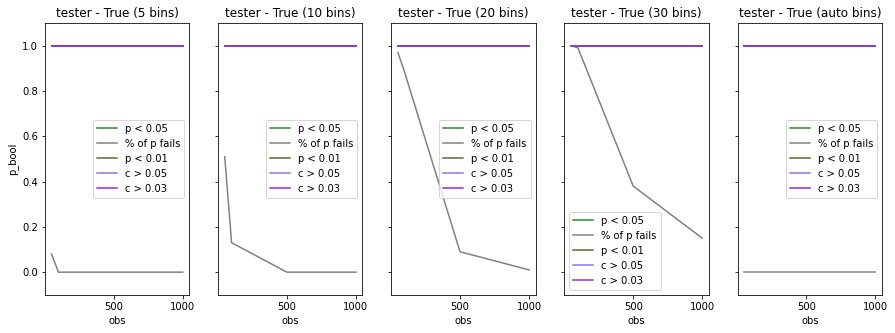

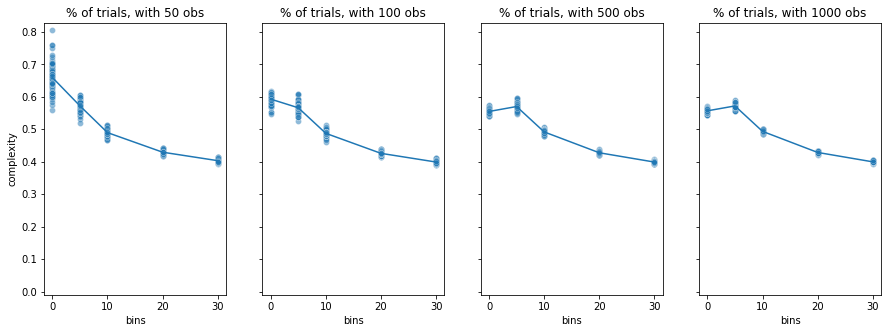

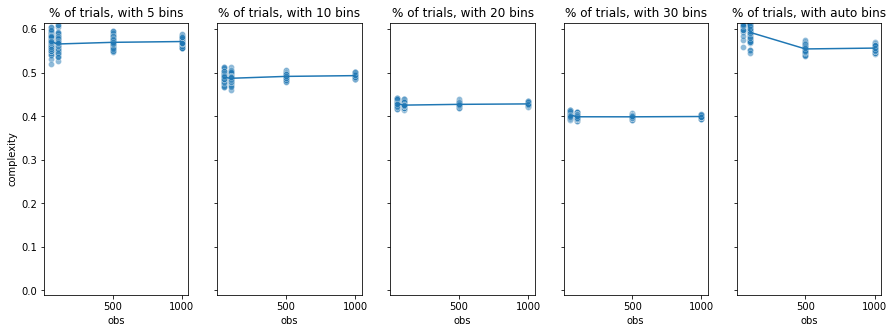

In [340]:
cs = ChiScan(True, case=CASES_FLIP['flip normal 5-8'], case_name='tester', ensembles=2, obs_range=[50,100,500,1000], trials=100, bin_range=[5,10,20,30,0], cp=nbsetup.cp)
cs.analyse()
ll = special(cs, p=True, c=True)
cs.plot()


gen results


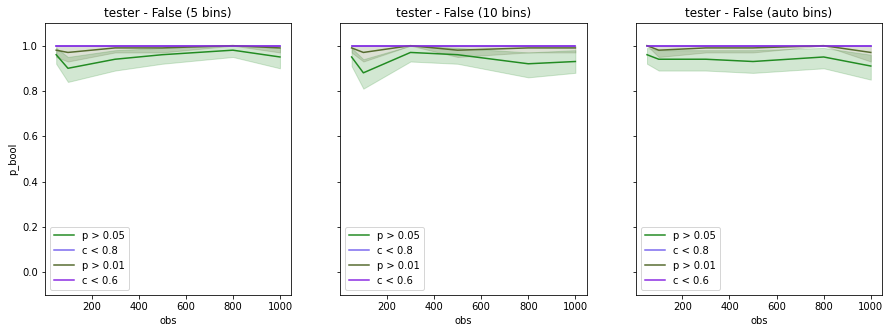

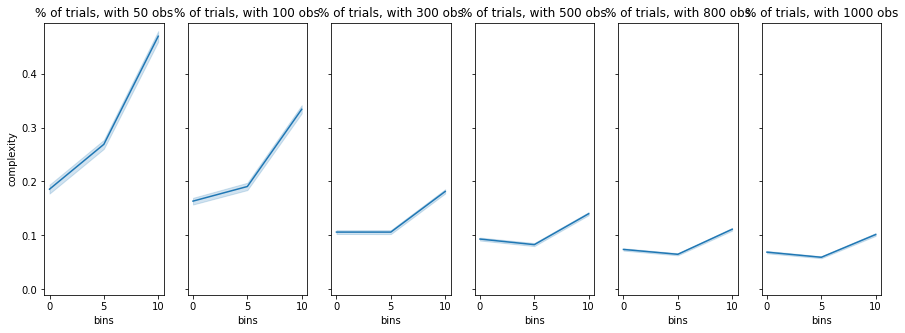

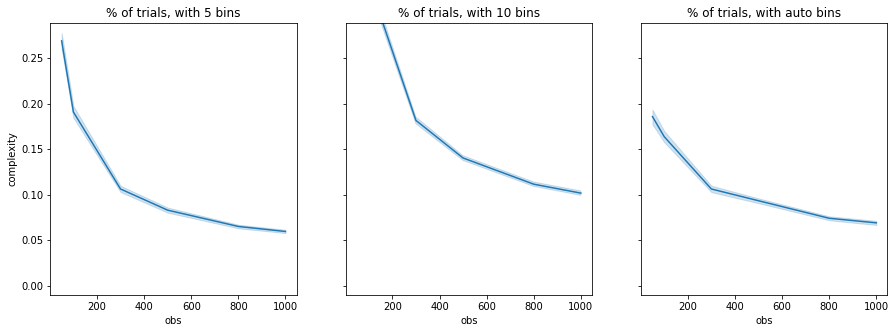

In [251]:
cs = ChiScan(False, case=CASES_TRUE['uniform'], case_name='tester', ensembles=20, obs_range=[50,100,300,500,800,1000], trials=100, bin_range=[5,10,0], cp=nbsetup.cp)
cs.analyse()
wl = cs.dataframe()
wl['complexity'] = wl['complexity']*(wl['obs']**0.5)
_, axes = cs.plot_bools(wl=wl, p_threshold=0.05, c_threshold=0.8, p_color='forestgreen', c_color='mediumslateblue')
fig, _ = cs.plot_bools(wl=wl, p_threshold=0.01, c_threshold=0.6, p_color='darkolivegreen', c_color='blueviolet', axes=axes)
cs.plot(wl)

gen results


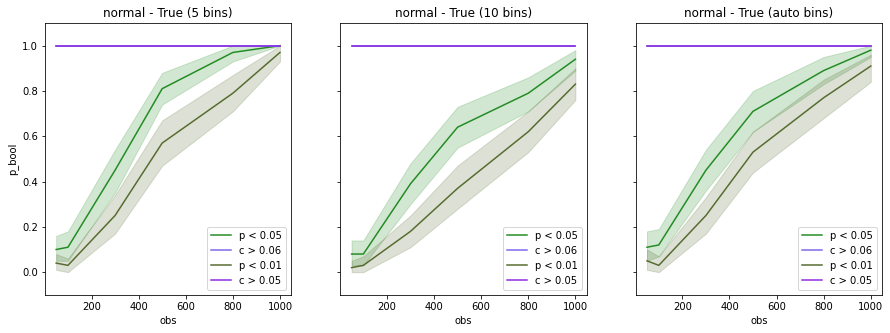

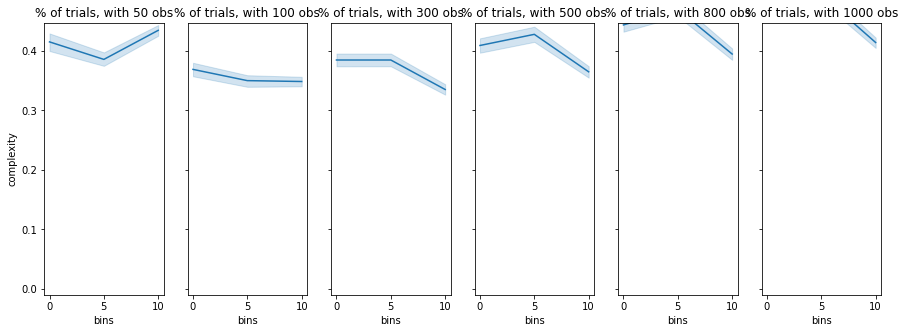

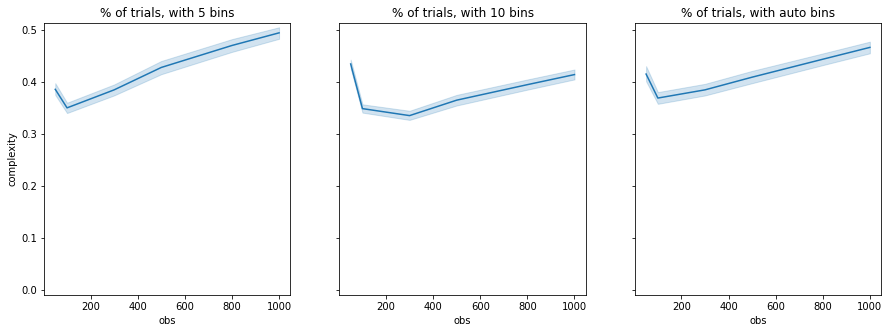

In [237]:
cs = ChiScan(False, case=CASES_SAME['normal'], case_name='normal', obs_range=[50,100,300,500,800,1000], trials=100, bin_range=[5,10,15,0], cp=nbsetup.cp)
cs.analyse()
wl = cs.dataframe()
wl['complexity'] = wl['complexity']*(wl['obs']**0.4)
_, axes = cs.plot_bools(wl=wl, p_threshold=0.05, c_threshold=0.06, p_color='forestgreen', c_color='mediumslateblue')
fig, _ = cs.plot_bools(wl=wl, p_threshold=0.01, c_threshold=0.05, p_color='darkolivegreen', c_color='blueviolet', axes=axes)
cs.plot(wl)

gen results


KeyError: 'bins'

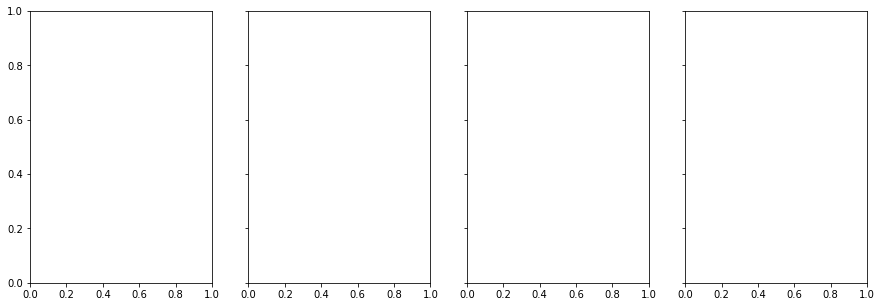

In [234]:
cs = ChiScan(False, case=CASES_SAME['normal'], case_name='normal', obs_range=[50,100,300,500,800,1000], trials=100, bin_range=[5,10,15,0], cp=nbsetup.cp)
cs.analyse()
wl = cs.dataframe()
wl['complexity'] = wl['complexity']*(wl['obs']**0.4)
_, axes = cs.plot_bools(wl=wl, p_threshold=0.05, c_threshold=0.06, p_color='forestgreen', c_color='mediumslateblue')
fig, _ = cs.plot_bools(wl=wl, p_threshold=0.01, c_threshold=0.05, p_color='darkolivegreen', c_color='blueviolet', axes=axes)
cs.plot(wl)

In [341]:
scans = {}
for is_complex, cases in ((False, CASES_SAME),(True, CASES_RAND)):
    for name, func in cases.items():
        cs = ChiScan(is_complex, case=func, case_name=name, obs_range=[50,100,500,1000,5000], ensembles=20, trials=100, bin_range=[10,20,0], cp=nbsetup.cp)
        cs.analyse()
        scans[name] = cs

gen results


In [400]:
def special(s, p=True, c=True, a=False):
    wl = s.dataframe()
    
    # plot p
    if p:
        _, axes = s.plot_bools(wl=wl, p_threshold=0.05, p_color='forestgreen', fails=True)
        s.plot_bools(wl=wl, p_threshold=0.01, p_color='darkolivegreen', axes=axes)
    
    # plot standards
    if c:
        _, axes = s.plot_bools(wl=wl, c_threshold=0.02, c_color='mediumpurple', axes=axes)
        s.plot_bools(wl=wl, c_threshold=0.03, c_color='blueviolet', axes=axes)

    # obs adjusted
    if a:
        wl['complexity'] = wl['complexity']*(wl['bins']**0.1)*(wl['obs']**0.5)
        s.plot_bools(wl=wl, c_threshold=0.8, c_color='darkorange', axes=axes)
        s.plot_bools(wl=wl, c_threshold=0.6, c_color='peru', axes=axes)
    return wl

,complexity,chi_p,obs,trial,bins,p_bool,p_fail,c_bool
0,1.060284,4.445415e-01,50,0,10,0,0,1
1,1.324690,4.534965e-01,50,0,20,0,0,1
2,0.000000,1.408130e-02,50,0,0,0,0,0
3,0.768198,3.697770e-01,50,1,10,0,0,1
4,1.178560,4.293624e-01,50,1,20,0,0,1
...,...,...,...,...,...,...,...,...
1495,1.583581,7.623585e-05,5000,98,20,1,0,1
1496,0.000000,1.003380e-04,5000,98,0,1,0,0
1497,2.159902,3.799385e-11,5000,99,10,1,0,1
1498,1.974062,5.080117e-08,5000,99,20,1,0,1


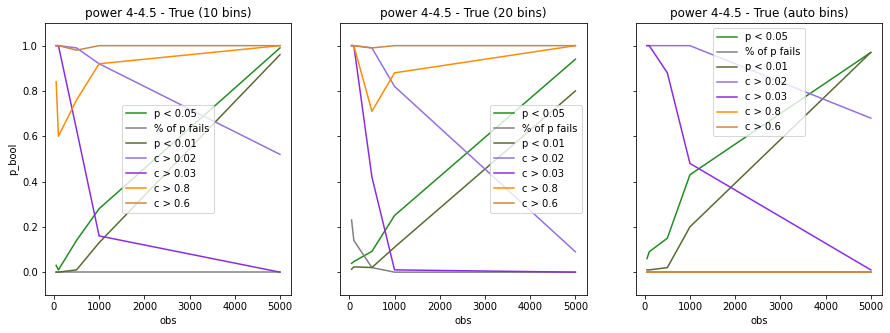

In [401]:
special(scans['power 4-4.5'], a=True)

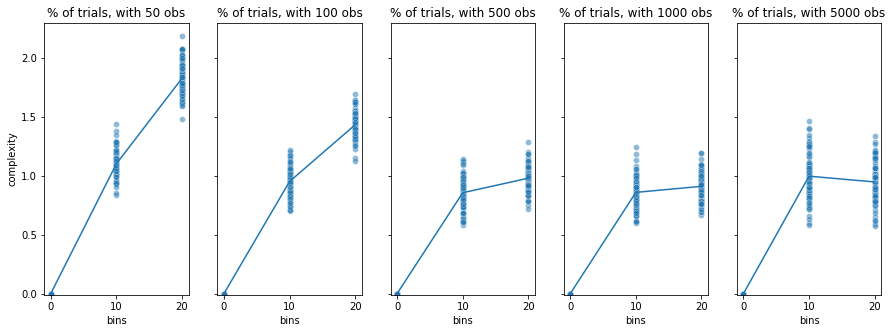

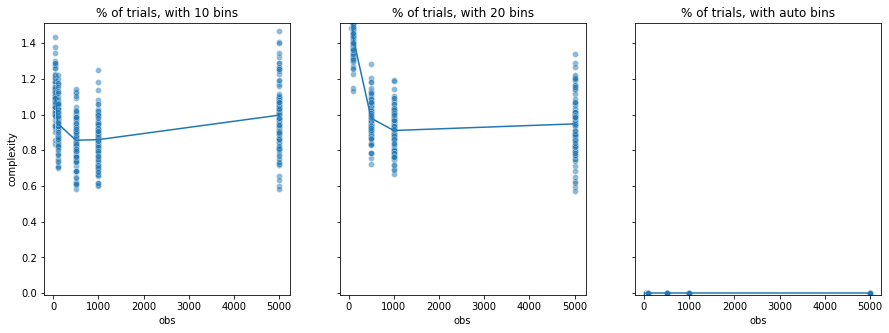

In [389]:
temp = scans['power 2'].dataframe()
temp['complexity'] = temp['complexity']*(temp['bins']**0.1)*(temp['obs']**0.6)
scans['power 2'].plot(temp)

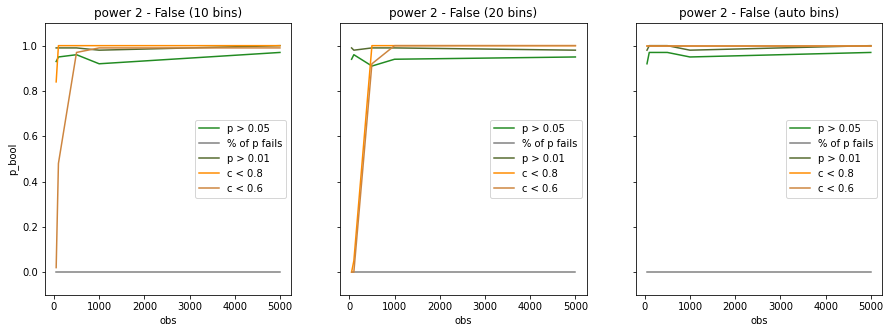

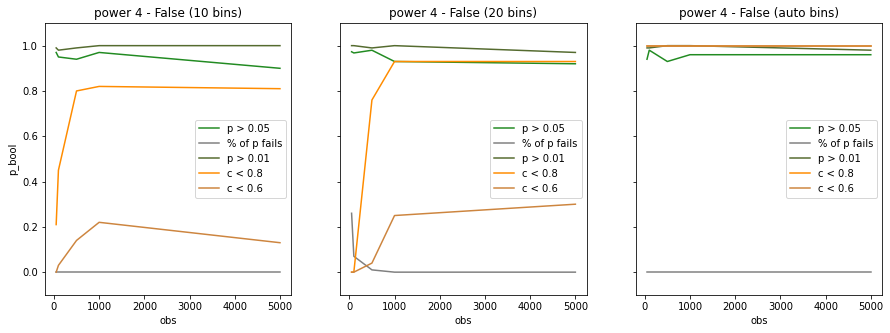

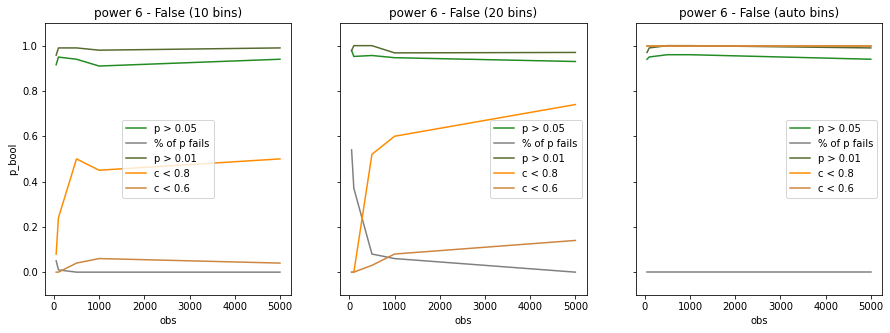

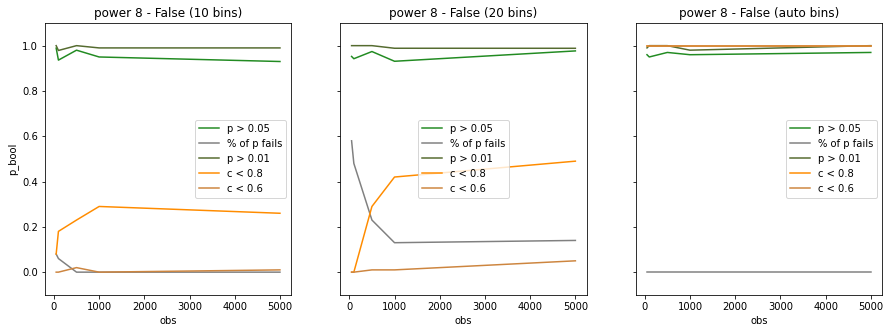

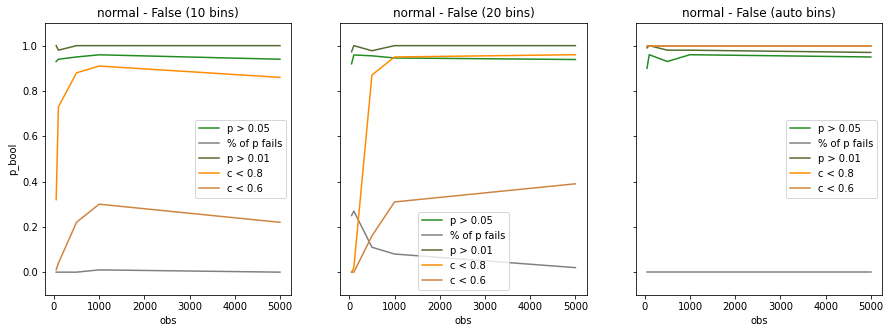

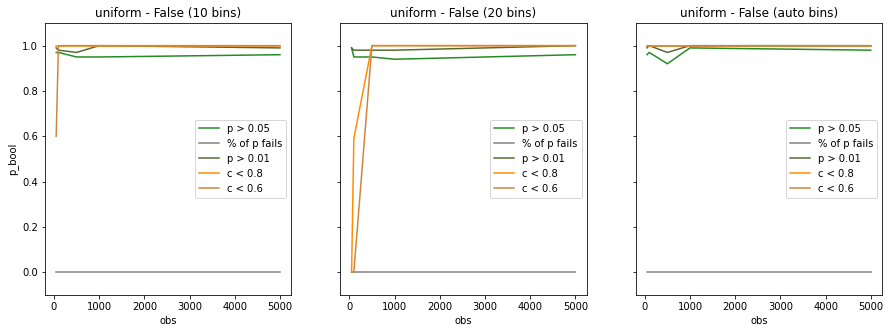

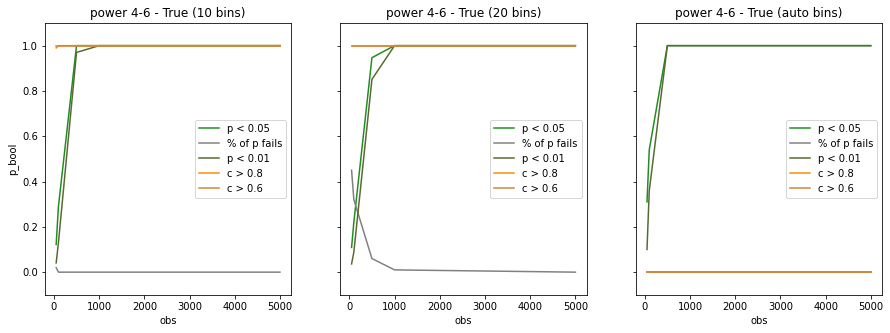

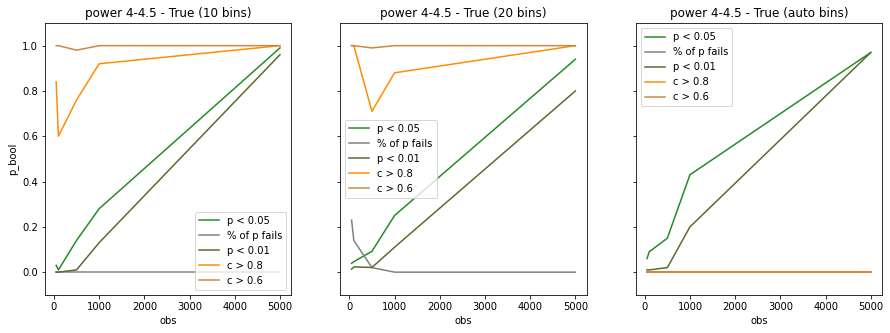

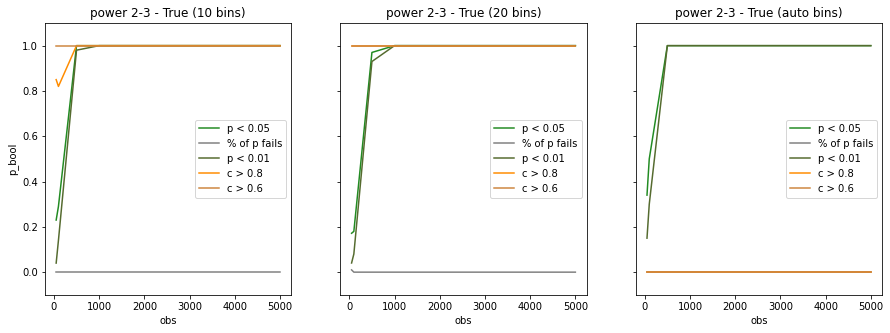

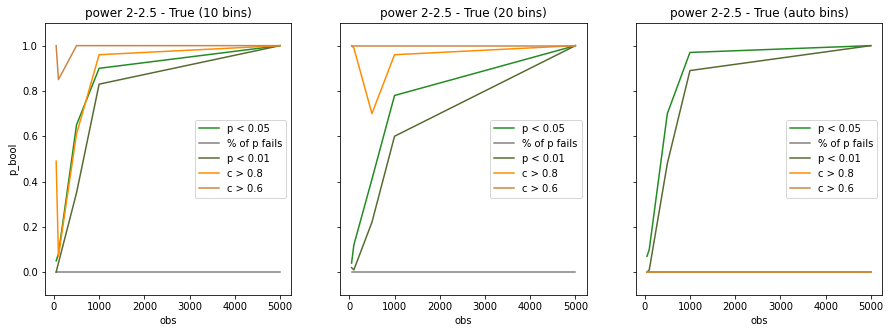

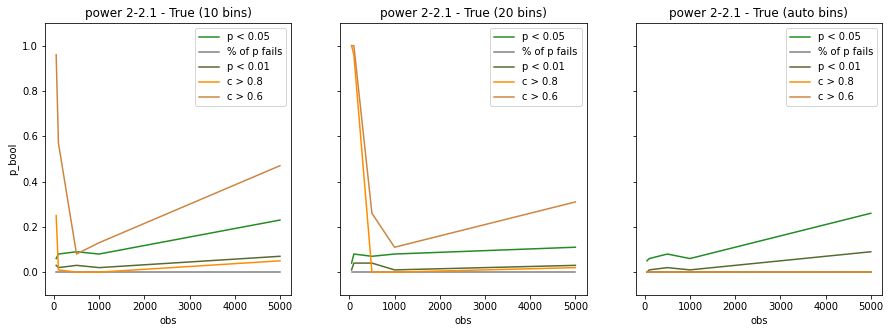

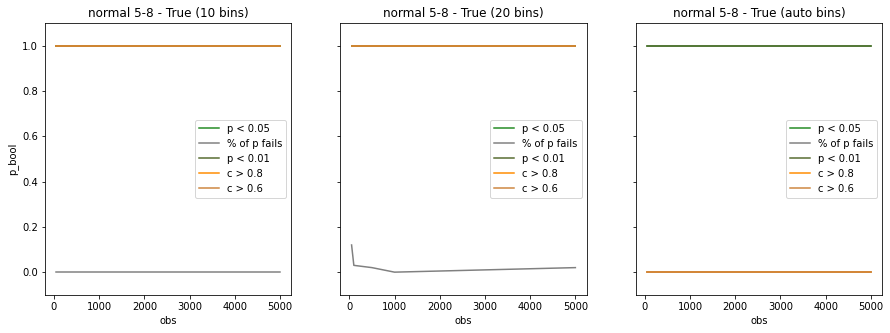

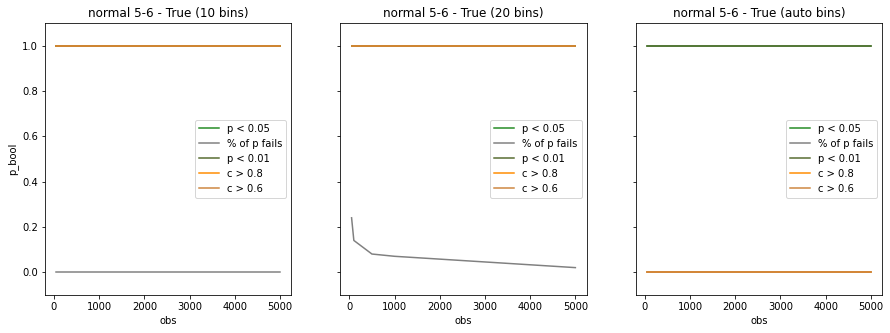

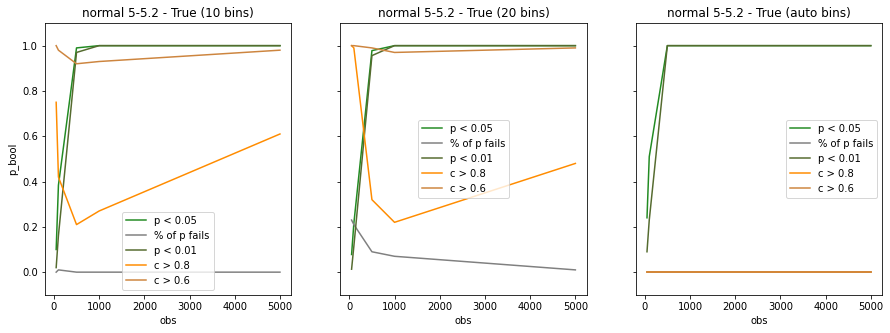

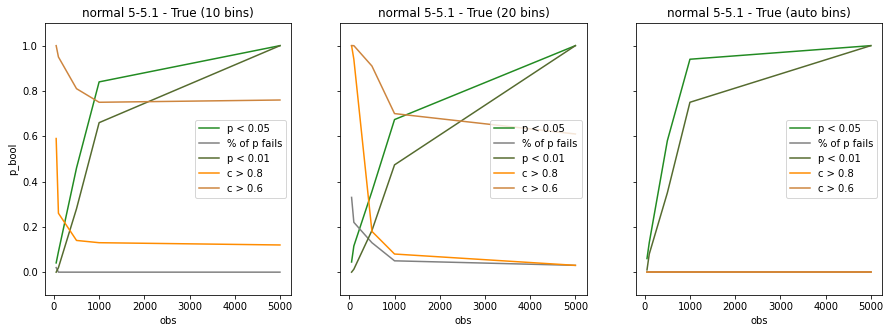

In [402]:
ALL = True
for name, s in scans.items():
    if ALL or name in ['flip power 4-4.5', 'flip power 2-2.5', 'flip power 2-2.1', 'flip normal 5-5.2']:
        special(s, a=True, c=False)

## def special(s, other=False):
    wl = s.dataframe()
    _, axes = s.plot_bools(wl=wl, p_threshold=1.0, c_threshold=0.05, p_color='white', c_color='orangered')
    wl['complexity'] = wl['complexity']*(wl['obs']**0.5)
    _, axes = s.plot_bools(wl=wl, p_threshold=0.05, c_threshold=0.9, p_color='forestgreen', c_color='mediumslateblue', axes=axes)
    fig, _ = s.plot_bools(wl=wl, p_threshold=0.01, c_threshold=0.6, p_color='darkolivegreen', c_color='blueviolet', axes=axes)
    #wl['complexity'] = wl['complexity']*(wl['obs']**0.3)
    #_, axes = s.plot_bools(wl=wl, p_threshold=0.05, c_threshold=0.2, p_color='forestgreen', c_color='mediumslateblue', axes=axes,fails=True)
    #fig, _ = s.plot_bools(wl=wl, p_threshold=0.01, c_threshold=0.18, p_color='darkolivegreen', c_color='blueviolet', axes=axes)
    if other:
        s.plot(wl)

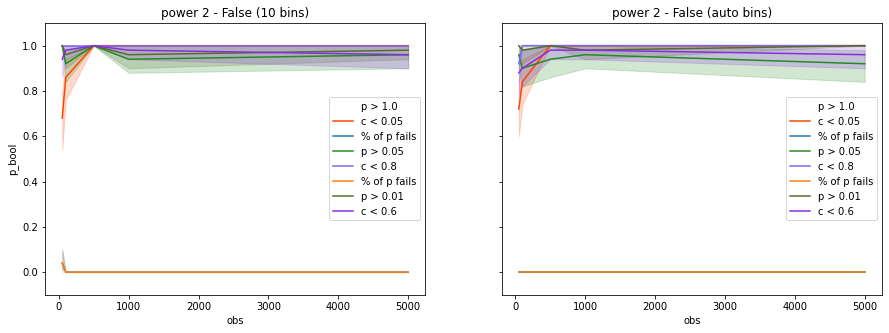

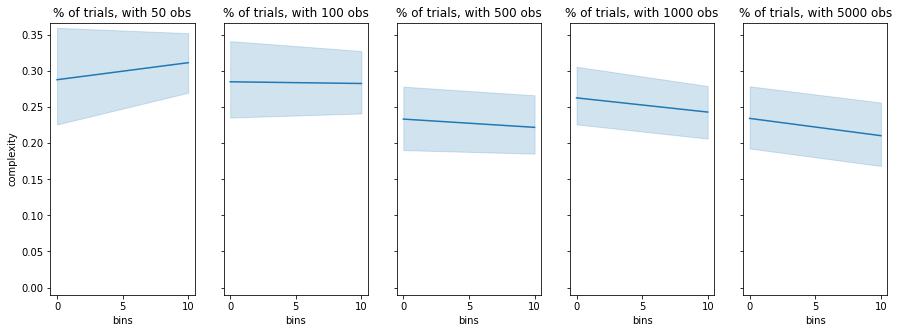

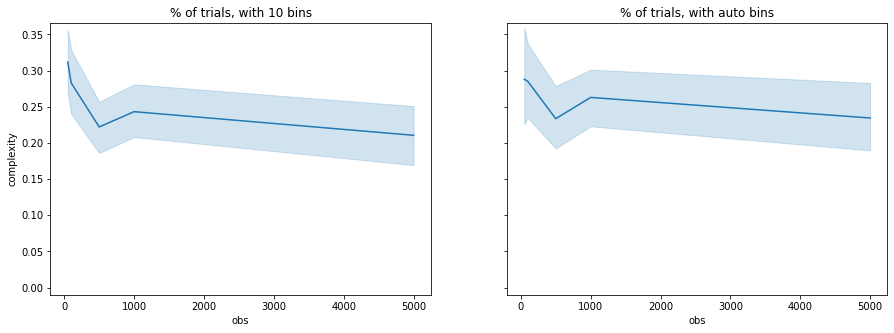

In [253]:
special(scans['power 2'], True)
